# Bruno Souza
# 
# Project: Investigation into the "No-show appointments" dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **For this analysis I have chosen the “No-show appointments” dataset**

This dataset contains information from over 100,000 medical appointments in the city of Vitoria, Espirito Santo, Brazil and is focused on the question of whether patients showed up for their appointment.

The data includes some descriptive characteristics for each patient, such as medical conditions, age, time elapsed between the appointment booking and the appointment itself, gender, whether the patient was sent an SMS to remind them of the appointment, and, of course, whether the patient showed up for their appointment. The period covered ranges from November 2015 to June 2016.

The questions we’ll try to answer in this analysis is which variable is more strongly correlated with whether the patient showed up for their appointment.

A deeper breakdown will be provided for the 3 variables that are more closely correlated with whether the patient showed up to their appointment, as well as for the neighbourhoods that had the most no-shows in the dataset.


In [3]:
# Import statements for packages that we are going to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from datetime import timedelta


<a id='wrangling'></a>
## Data Wrangling

> **Notice**: In this section we are going to load and inspect the data to find out if any changes have to be made to the original data.

### General Properties

In [4]:
# Data import statement
df = pd.read_csv(r'..\noshowappointments-kagglev2-may-2016.csv')

# The head function will allow us to visually inspect the data
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
# The info function will allow us to find out whether there are any null values in the dataset as well as the data type for
# each column.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Data Cleaning

> Based on the information we gathered above the columns we are going to clean are:

> **No-show**: Instead of using 'Yes' or 'No' for whether the patient has showed up to their appointment we are going to change that to 0 and 1. This way we can calculate the correlation between any of the patients' characteristics and whether they showed up to their appointment.

> **Gender**: Similarly, we are going to change the gender column to 0s and 1s, with 0 being females and 1 being males.

> **ScheduledDay and AppointmentDay**: The two date columns are going to be converted to proper datetime format so we can calculate the number of days between the scheduling and the appointment. First we are going to remove any unwanted characters, then convert to datetime, and lastly we are going to calculate the time elapsed between the schedule date and the appointment date. The answer will be given in days.


In [6]:
# First we create a new column for whether the patient showed up to their appointment. 0 is for patients who didn't show up
# and 1 is for patients who showed up.
df['no_show'] = df['No-show'].map({'Yes': 0, 'No': 1})

# Now we create a new column for gender, in which females are represented by 0 and males are represented by 1.
df['gender'] = df['Gender'].map({'F': 0, 'M': 1})

# Now we remove the unwanted characters from the date columns
df['scheduled_day'] = df['ScheduledDay'].apply(lambda x: x.split('T')[0])
df['appointment_day'] = df['AppointmentDay'].apply(lambda x: x.split('T')[0])

# The date columns can now be converted to datetime format
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])

# The time elapsed between schedule day and appointment day is calculated in seconds and converted to days
# (1 day = 86,400 seconds)
df['seconds_elapsed'] = ((df['appointment_day']-df['scheduled_day']).dt.total_seconds())
df['days_elapsed'] = df['seconds_elapsed']/86400


<a id='eda'></a>
## Exploratory Data Analysis

### Question 1: Which variables are more strongly correlated with whether the patient showed up for their appointment?

> **Rationale**: There is a suspicion that receiving an SMS will have greater impact on a patient showing up for their appointment. Another suspicion is that a shorter time elapsed between the schedule day and the appointment day will also impact turn out, since patients who book appointments too much in advance might forget about them or the issue they had has gone away. But we also need to explore the impact of other variables and find out which one impact turn out the most.

> **Point of attention**: Two variables are strongly correlated if their correlation index is close to either 1 or -1. If the correlation index is close to 1 it means they are positively correlated, if the correlation index is close to -1 it means they are negatively correlated.


Text(0.5, 1.0, 'Correlation with no_show')

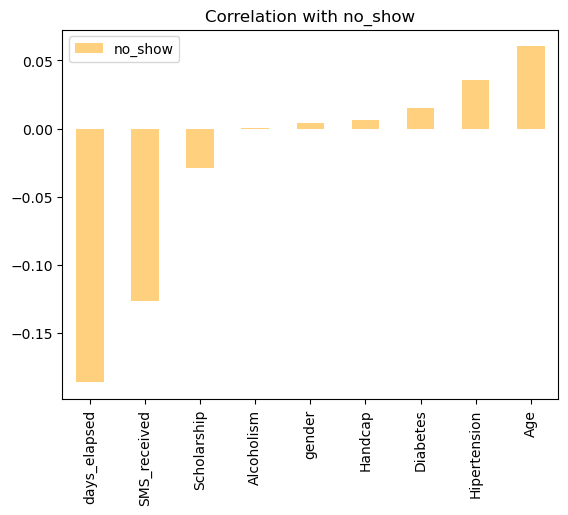

In [7]:
# To get the correlation between 'no_show' and the other variables we need first to calculate a correlation matrix for all
# the variables in the dataset.
corr_matrix = df[['gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received','days_elapsed', 'no_show']].corr()

# Since the correlation matrix gives us correlations we are not interested in we are going to remove them from the matrix.
corr_matrix.drop(columns=['gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received','days_elapsed'], inplace=True)

# We are also going to remove the correlation between 'no_show' and itself because obviously that is equal to 1. We are
# also going to sort the matrix to find out which variables are most strongly correlated with 'no_show'.
corr_matrix = corr_matrix.drop(corr_matrix[corr_matrix['no_show'] == 1].index).sort_values('no_show', ascending=True)

# Now we make a bar graph with the results we have.
corr_matrix.plot(kind='bar',alpha=0.5, color= 'orange')
plt.title('Correlation with no_show')


> **Result**: We can see from the graph above that the 4 variables most strongly correlated with showing up for the appointment are 'days_elapsed', 'SMS_received', and 'Age'. The first two are negatively correlated and the correlation is mild, while the last one is positively correlated and the correlation is weak. Curiosly, none of the stated health conditions in the dataset (hipertension, diabeter, alcoholism and handicap) seem to be correlated with whether the patient showed up for their appointment. The fact that the patient receive an incentive from the governemnt (scholarship) doesn't seem to be correlated either.

> **Days elapsed**: the breakdown for the 'days_elapsed' variable can be seen in the graph below. We can see that on average the number of days that passed between schedule day and the appointment day is 15.8 days for people who didn't show up for their appointment. The same average is 8.7 days for people who showed up for their appointment. This suggests (along with the correlation we saw earlier) that people tend to show up for appointments booked closer to the scheduling day, although the standard deviation for both averages is quite high, so more factors contribute to predicting whether a patient will show up.


Average number of days elapsed for patients who didn't show for their appointment and patients who did
no_show
0    15.831489
1     8.754659
Name: days_elapsed, dtype: float64

Standard deviation of days elapsed for patients who didn't show for their appointment and patients who did
no_show
0    16.605912
1    14.550398
Name: days_elapsed, dtype: float64


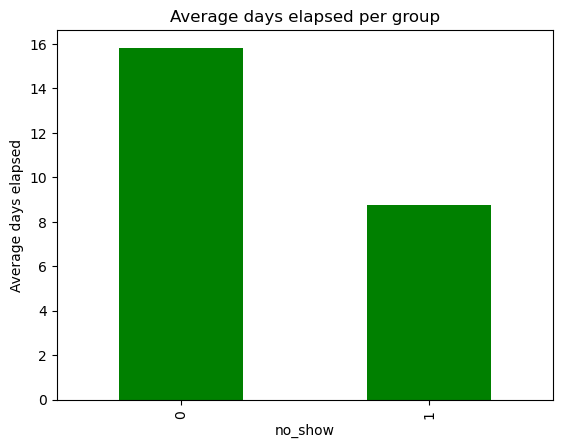

In [10]:
# Printing the results described above and the corresponding graph
print("Average number of days elapsed for patients who didn't show for their appointment and patients who did")
print(df.groupby('no_show')['days_elapsed'].mean())
print("\nStandard deviation of days elapsed for patients who didn't show for their appointment and patients who did")
print(df.groupby('no_show')['days_elapsed'].std())
df.groupby('no_show')['days_elapsed'].mean().plot(kind='bar', color='green')
plt.title('Average days elapsed per group')
plt.xlabel('no_show')
plt.ylabel('Average days elapsed')
plt.show();


> **SMS**: the breakdown for the 'SMS_received' variable can be seen in the graph below. We can see that nearly 44% of the patients who didn't show up for their appointment received and SMS, while approximately 29% of the patients who showed up for their appointment received an SMS. Just like in the previous case, the standard deviation for both groups is quite high so very little in terms of inference can be made (as also suggested by the correlation index).


Percentage of patients who received an SMS for patients who didn't show for their appointment and patients who did
no_show
0    0.438371
1    0.291334
Name: SMS_received, dtype: float64

Standard deviation of patients who received an SMS for patients who didn't show for their appointment and patients who did
no_show
0    0.496198
1    0.454380
Name: SMS_received, dtype: float64


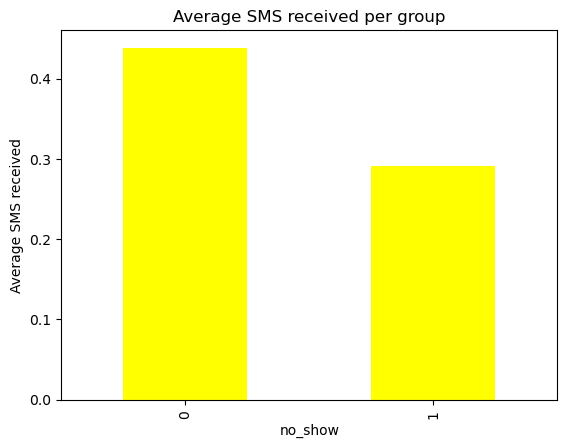

In [11]:
# Printing the results described above and the corresponding graph
print("Percentage of patients who received an SMS for patients who didn't show for their appointment and patients who did")
print(df.groupby('no_show')['SMS_received'].mean())
print("\nStandard deviation of patients who received an SMS for patients who didn't show for their appointment and patients who did")
print(df.groupby('no_show')['SMS_received'].std())
df.groupby('no_show')['SMS_received'].mean().plot(kind='bar', color='yellow')
plt.title('Average SMS received per group')
plt.xlabel('no_show')
plt.ylabel('Average SMS received')
plt.show();


> **Age**: the breakdown for the 'Age' variable can be seen in the graph below. The average age of patients who showed up for their appointment is 34.3 years, while the patients who didn't show up for their appointment have ana average age of 37.8 years. The standard deviation for both groups is also quite high, which indicates only a small effect of age on the likelihood of a patient showing up for their appointment.


Average age of patients who didn't show for their appointment and patients who did
no_show
0    34.317667
1    37.790064
Name: Age, dtype: float64

Standard deviation of patients' age for patients who didn't show for their appointment and patients who did
no_show
0    21.965941
1    23.338878
Name: Age, dtype: float64


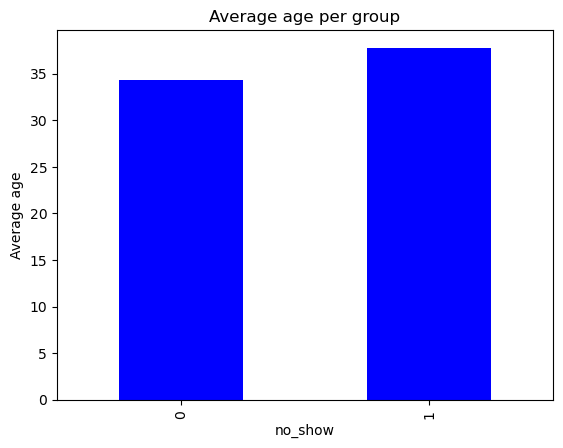

In [12]:
# Printing the results described above and the corresponding graph
print("Average age of patients who didn't show for their appointment and patients who did")
print(df.groupby('no_show')['Age'].mean())
print("\nStandard deviation of patients' age for patients who didn't show for their appointment and patients who did")
print(df.groupby('no_show')['Age'].std())
df.groupby('no_show')['Age'].mean().plot(kind='bar', color='blue')
plt.title('Average age per group')
plt.xlabel('no_show')
plt.ylabel('Average age')
plt.show();


### Question 2: Is there much difference across neighbourhoods on how likely a patient is to show up for their appointment?

> **Rationale**: For this question we are going to look more closely at the top 5 neighbourhoods whose patients showed up for their appointment and at the bottom 5. We will look at how often they show up and how many patients are there per neighbourhood to find out if the results are meaningful. We are also going to look at how many patients have showed up for their appointment as a proportion of the entire population. Lastly, we'll create a histogram for age distribution of the population we're analyzing.


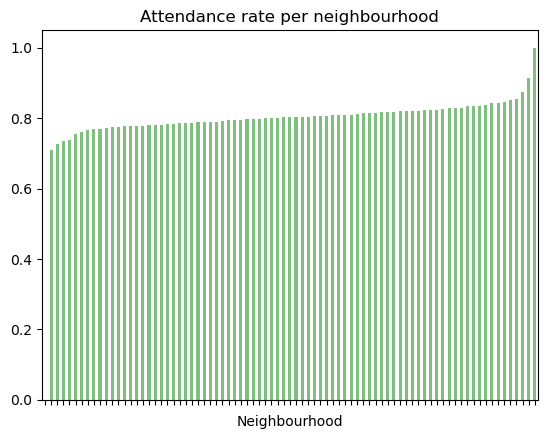

Average attendance rate for the entire dataset:
0.798067440534892
 
Neighbourhood
ILHAS OCEÂNICAS DE TRINDADE    0.000000
SANTOS DUMONT                  0.710815
SANTA CECÍLIA                  0.725446
SANTA CLARA                    0.735178
ITARARÉ                        0.737336
                                 ...   
SOLON BORGES                   0.852878
MÁRIO CYPRESTE                 0.854447
AEROPORTO                      0.875000
ILHA DO BOI                    0.914286
PARQUE INDUSTRIAL              1.000000
Name: no_show, Length: 81, dtype: float64
No-show
No     88208
Yes    22319
Name: No-show, dtype: int64


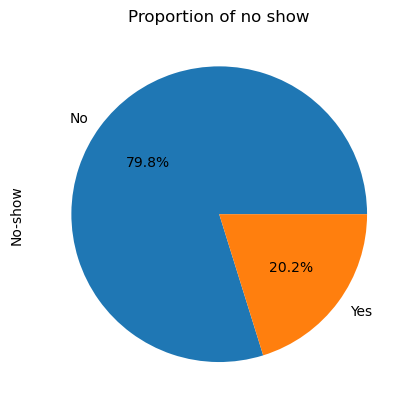

As you remember, "No" means the patient showed up for their appointment and "Yes" means they did not show up.
The average age of our population is:
37.08887421173107


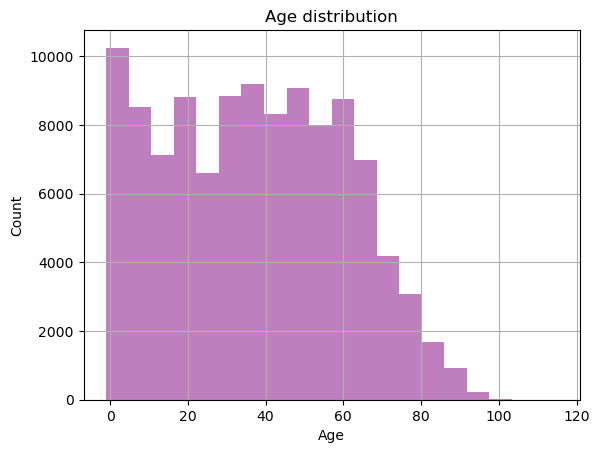

In [21]:
# First we are going to calculate the attendance rate for the entire dataset.
avg_all = df['no_show'].mean()

# Then we will calculate the attendance rate for each neighbourhood.
avg_neighbourhood = df.groupby('Neighbourhood')['no_show'].mean().sort_values(ascending=True)

# Now we are going to plot a bar chart with the attendance rate for each neighbourhood...
avg_neighbourhood.plot(kind='bar',alpha=0.5, color= 'green').set_xticklabels([])
plt.title('Attendance rate per neighbourhood')
plt.show();

# ...and print all the results.
print("Average attendance rate for the entire dataset:")
print(avg_all)
print(" ")
print(avg_neighbourhood)

# Here we are going to show what the global attendance rate is for the entire dataset
count_no_show = df.groupby('No-show')['No-show'].count()
print(count_no_show)
count_no_show_graph = count_no_show.plot(y='No-show', kind='pie', autopct='%1.1f%%')
plt.title('Proportion of no show')
plt.show();
print('As you remember, "No" means the patient showed up for their appointment and "Yes" means they did not show up.')

# Finally, we'll create a histogram to look at the age distibution of our dataset
avg_age = df.Age.mean()
print('The average age of our population is:')
print(avg_age)

df.Age.hist(alpha=0.5, bins=20, label='Age', color='purple')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show();

> **Results**: We can see the bottom 5 neighbourhoods in terms of attendance are ILHAS OCEÂNICAS DE TRINDADE, SANTOS DUMONT, SANTA CECÍLIA, SANTA CLARA and ITARARÉ. The top 5 neighbourhoods in terms of attendance are SOLON BORGES, MÁRIO CYPRESTE, AEROPORTO, ILHA DO BOI and PARQUE INDUSTRIAL. Curiously, ILHAS OCEÂNICAS DE TRINDADE had zero attendance and PARQUE INDUSTRIAL had 100% attendance, which suggests these neighbourhoods might have very few residents. Also, the graph above suggests there's little variation across attendance rates in different neighbourhoods, with the average attendance being close to 80%.

> **Next steps**: Have a closer look at the data for the 10 neighbourhoods listed above.


Neighbourhood
ITARARÉ                        3514
SANTOS DUMONT                  1276
SANTA CLARA                     506
SOLON BORGES                    469
SANTA CECÍLIA                   448
MÁRIO CYPRESTE                  371
ILHA DO BOI                      35
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, dtype: int64


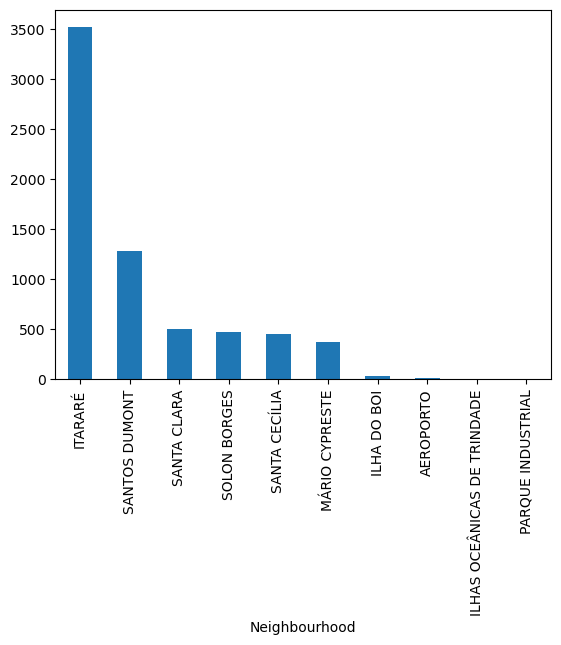

In [17]:
# First we drop all rows with neighbourhoods that are not the 10 neighbourhoods we listed above.
selected_neighbourhoods = ['ILHAS OCEÂNICAS DE TRINDADE', 'SANTOS DUMONT', 'SANTA CECÍLIA', 'SANTA CLARA', 'ITARARÉ', 'SOLON BORGES', 'MÁRIO CYPRESTE', 'AEROPORTO', 'ILHA DO BOI', 'PARQUE INDUSTRIAL']
ten_neighbourhoods = df[df.Neighbourhood.isin(selected_neighbourhoods)]

# Now we look at how many patients are there per neighbourhood.
print(ten_neighbourhoods.groupby('Neighbourhood')['Neighbourhood'].count().sort_values(ascending=False))
ten_neighbourhoods.groupby('Neighbourhood')['Neighbourhood'].count().sort_values(ascending=False).plot(kind='bar');


> **Results**: We can see the bottom 4 neighbourhoods indeed have very few patients, not surprisingly because Ilha do Boi and Ilhas Oceânicas de Trindade are islands so not many people live there. Parque Industrial is an industrial area and Aeroporto must refer to the airport region. Given their low representation these neighbourhoods will also be dropped from the analysis.

> **Graphs below**: To facilitate the following visualizations we are going to give the neighbourhoods that were in the bottom 5 the color blue, and the neighbourhood that were in the top 5 the color green. So, SOLON BORGES and MÁRIO CYPRESTE neighbourhoods will be green and the rest will be blue.


                 no_show  days_elapsed  SMS_received        Age
Neighbourhood                                                  
ITARARÉ         0.737336     11.006545      0.327547  35.826693
MÁRIO CYPRESTE  0.854447      5.671159      0.229111  36.873315
SANTA CECÍLIA   0.725446     21.948661      0.399554  40.904018
SANTA CLARA     0.735178     11.790514      0.322134  37.581028
SANTOS DUMONT   0.710815     12.267241      0.351097  37.744514
SOLON BORGES    0.852878     12.891258      0.381663  44.816631
 


C:\Users\bsouza015\AppData\Local\Temp\ipykernel_11232\3463851653.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(six_neighbourhoods.groupby('Neighbourhood')['no_show', 'days_elapsed', 'SMS_received', 'Age'].mean())


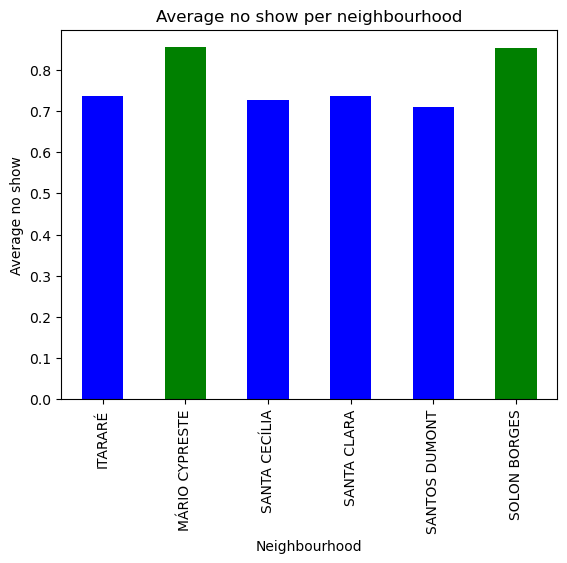

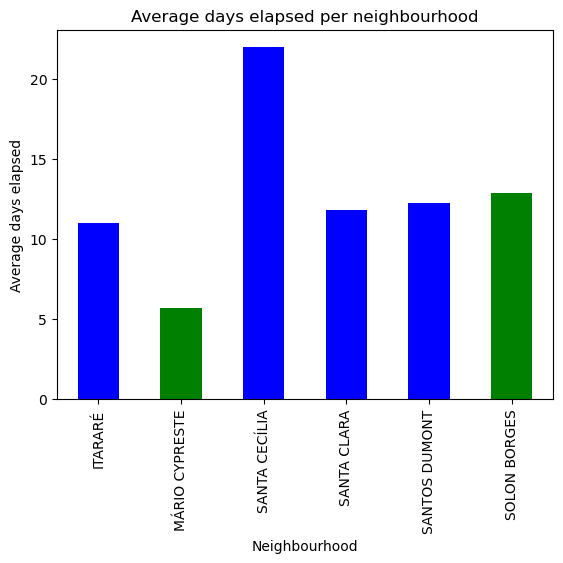

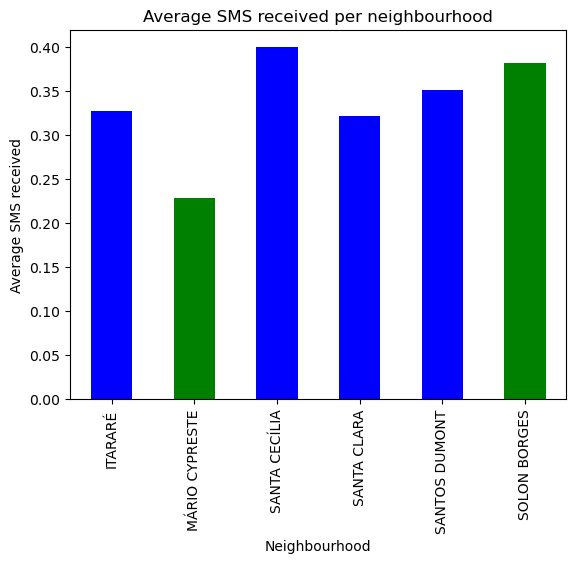

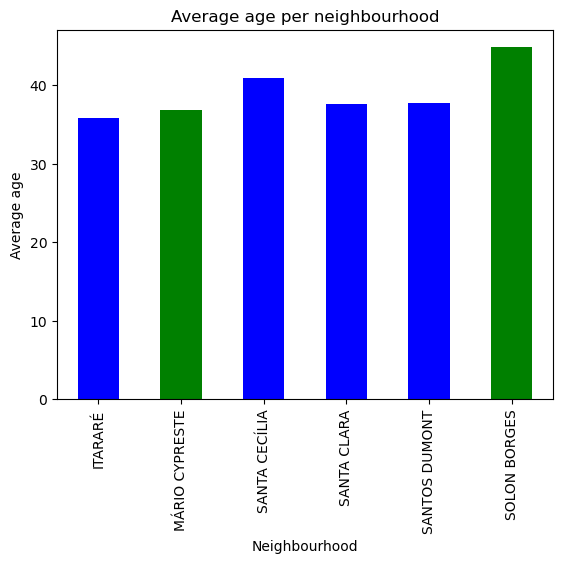

In [18]:
# Same as before we drop all rows with the 4 neighbourhoods metioned above
selected_neighbourhoods = ['SANTOS DUMONT', 'SANTA CECÍLIA', 'SANTA CLARA', 'ITARARÉ', 'SOLON BORGES', 'MÁRIO CYPRESTE']
six_neighbourhoods = df[df.Neighbourhood.isin(selected_neighbourhoods)]

# Now we define a color for each neighbourhood...
colors = {'SANTOS DUMONT': 'blue', 'SANTA CECÍLIA': 'blue', 'SANTA CLARA': 'blue', 'ITARARÉ': 'blue', 'SOLON BORGES': 'green', 'MÁRIO CYPRESTE': 'green'}

# ...and we calculate the statistics for each neighbourhood to help us go through the graphs
print(six_neighbourhoods.groupby('Neighbourhood')['no_show', 'days_elapsed', 'SMS_received', 'Age'].mean())
print(" ")

# No show graph
mean_no_show = six_neighbourhoods.groupby('Neighbourhood')['no_show'].mean()
no_show_graph = mean_no_show.plot(y='no_show', kind='bar', color=mean_no_show.index.map(colors))
plt.title('Average no show per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average no show')
plt.show();

# Days elapsed graph
mean_days_elapsed = six_neighbourhoods.groupby('Neighbourhood')['days_elapsed'].mean()
days_elapsed_graph = mean_days_elapsed.plot(y='days_elapsed', kind='bar', color=mean_days_elapsed.index.map(colors))
plt.title('Average days elapsed per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average days elapsed')
plt.show();

# SMS received graph
mean_SMS_received = six_neighbourhoods.groupby('Neighbourhood')['SMS_received'].mean()
SMS_received_graph = mean_SMS_received.plot(y='SMS_received', kind='bar', color=mean_SMS_received.index.map(colors))
plt.title('Average SMS received per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average SMS received')
plt.show();

# Age graph
mean_age = six_neighbourhoods.groupby('Neighbourhood')['Age'].mean()
age_graph = mean_age.plot(y='Age', kind='bar', color=mean_age.index.map(colors))
plt.title('Average age per neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average age')
plt.show();


<a id='conclusions'></a>
## Conclusions

> **Results**: The graphs in the section above confirm the suspicions we had regarding the effect of the independent variables in explaining the likelihood of a patient showing up for their appointment, even when we break down the data into the neighbourhoods were the patients had the lowest and highest attendance. There simply isn't enough evidence, not even in these extreme cases, that allow us to draw any definitive conclusions. The only variable that had some explanatory power was the time between schedule day an appointment day, but even the correlation index for this variable is rather low and the R-squared of this variable would be even lower. A non-linear regression using all the variables at our disposal would probably be best suited for such analysis, but this is not the scope of this project.